# Лабораторная работа 1

Катков Павел Ильич, 3 вариант.

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [3]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



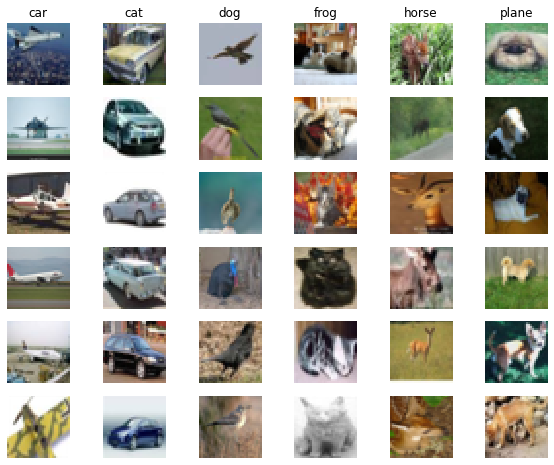

In [4]:
classes = ['car', 'cat', 'dog', 'frog', 'horse', 'plane']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

Возьмём выборку поменьше (5000 на обучение, 1000 на тест), чтобы не тратить много времени на обучение.

In [5]:
count_train = 5000
count_test = 1000

X_train, y_train = X_train[:count_train], y_train[:count_train]
X_test, y_test = X_test[:count_test], y_test[:count_test]


X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [7]:
from scripts.classifiers.k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [8]:
result = classifier.predict(X_test, k=5)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


<AxesSubplot:>

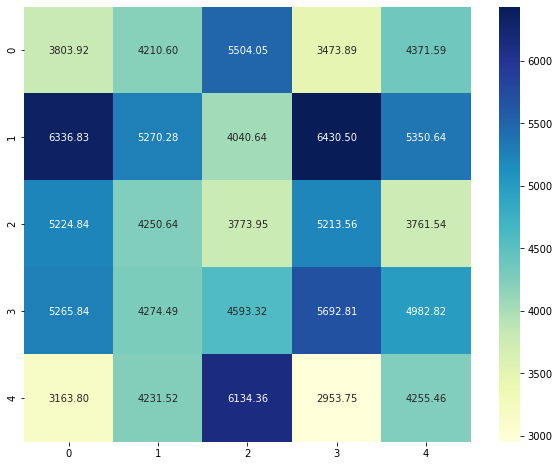

In [9]:
import seaborn as sns

sns.heatmap(classifier.dists[:5, :5], annot=True, fmt ='.2f', cmap="YlGnBu")


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [10]:
accuracy = np.sum(result == y_test) / result.shape[0]
print("accuracy:", accuracy)

accuracy: 0.278


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

Text(0, 0.5, 'Точность')

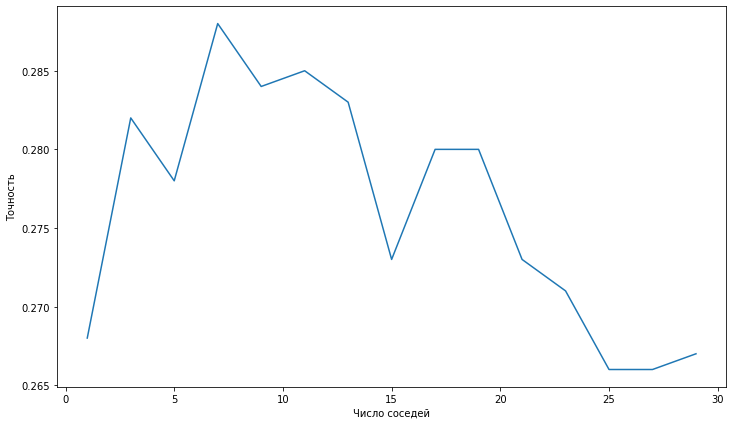

In [11]:
import pandas as pd

accs = {}
for k in range(1, 30, 2):
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test, k=k)
    accs[k] = np.sum(y_pred == y_test) / y_pred.shape[0]
    
pd.Series(accs).plot(figsize=(12,7))
plt.xlabel('Число соседей')
plt.ylabel('Точность')

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [12]:
folds = 5

x_train_folds = np.array_split(X_train, folds)
y_train_folds = np.array_split(y_train, folds)

accs = np.zeros((folds, len(list(range(1, 30, 2)))))

#один цикл по 5 фолдам, второй цикл по числу соседей

for i in range(folds):
    x_train_fold = np.concatenate(x_train_folds[:i] + x_train_folds[i+1:])
    y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
    
    x_test_fold = x_train_folds[i]
    y_test_fold = y_train_folds[i]

    classifier.train(x_train_fold, y_train_fold)
    
    for j, k in enumerate(list(range(1, 30, 2))):
        y_test_pred = classifier.predict(x_test_fold, k)
        accs[i, j] = np.sum(y_test_pred == y_test_fold) / y_test_fold.shape[0]

In [13]:
accs

array([[0.263, 0.257, 0.265, 0.274, 0.271, 0.28 , 0.266, 0.26 , 0.267,
        0.274, 0.271, 0.275, 0.269, 0.274, 0.269],
       [0.257, 0.263, 0.275, 0.29 , 0.3  , 0.302, 0.301, 0.302, 0.289,
        0.299, 0.295, 0.288, 0.291, 0.292, 0.288],
       [0.264, 0.273, 0.295, 0.296, 0.291, 0.292, 0.282, 0.292, 0.289,
        0.293, 0.287, 0.289, 0.282, 0.282, 0.293],
       [0.278, 0.282, 0.298, 0.301, 0.294, 0.286, 0.29 , 0.292, 0.286,
        0.285, 0.283, 0.275, 0.278, 0.268, 0.269],
       [0.266, 0.27 , 0.284, 0.29 , 0.29 , 0.278, 0.288, 0.285, 0.278,
        0.289, 0.288, 0.285, 0.289, 0.284, 0.274]])

In [14]:
list(range(1, 30, 2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [15]:
np.argmax(np.mean(accs, axis=0))

3

Лучшее число соседей = 7 (3ый элемент массива соседей)

1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.

In [16]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
pred = classifier.predict(X_test, k = 7)
print(np.sum(y_test == pred) / pred.shape[0])

0.288


1.11 Сделайте выводы по результатам 1 части задания.

Классификатор KNN очень примитивный и его точность далека от совершенства (менее 29%).

Подбор оптимального параметра числа соседей с использованием кросс-валидации не помог существенно улучшить результат.

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [3]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [4]:
X_val = X_train[5000: 5500]
y_val = y_train[5000: 5500]

X_dev = X_train[5500: 6000]
y_dev = y_train[5500: 6000]

X_test = X_test[:500]
y_test = y_test[:500]

X_train = X_train[:5000]
y_train = y_train[:5000]

In [5]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

In [6]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)
print('Validation shape: ', X_dev.shape)
print('Dev shape: ', X_dev.shape)

Train shape:  (5000, 3072)
Test shape:  (500, 3072)
Validation shape:  (500, 3072)
Dev shape:  (500, 3072)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[131.4542 136.3766 132.681  130.7926 135.7598 132.0316 131.6824 136.535
 132.6828 132.6776]


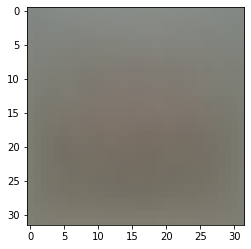

(5000, 3073) (500, 3073) (500, 3073)


In [7]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [8]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.473612
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [9]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 8.949113 analytic: 8.949109, relative error: 2.352331e-07
numerical: 11.751763 analytic: 11.751758, relative error: 2.387406e-07
numerical: 12.237899 analytic: 12.237892, relative error: 2.701167e-07
numerical: -0.933569 analytic: -0.933573, relative error: 1.994037e-06
numerical: -5.865430 analytic: -5.865431, relative error: 1.408533e-07
numerical: -0.714753 analytic: -0.714758, relative error: 3.263105e-06
numerical: 0.325712 analytic: 0.325708, relative error: 5.592666e-06
numerical: 13.799699 analytic: 13.799693, relative error: 2.234208e-07
numerical: 11.213875 analytic: 11.213871, relative error: 2.151150e-07
numerical: -0.851745 analytic: -0.851752, relative error: 4.209012e-06
numerical: -3.882708 analytic: -3.882712, relative error: 4.593120e-07
numerical: 10.461475 analytic: 10.461471, relative error: 2.158563e-07
numerical: -0.443237 analytic: -0.443241, relative error: 4.596628e-06
numerical: -5.109526 analytic: -5.109528, relative error: 2.804520e-07
numerical:

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [10]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.473612e+00 computed in 0.154433s
vectorized loss: -7.713684e-03 computed in 0.084993s
Loss difference: 2.481326
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [11]:
from scripts.classifiers import Softmax

softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 761.401717
iteration 100 / 1500: loss 278.666851
iteration 200 / 1500: loss 102.032183
iteration 300 / 1500: loss 37.397738
iteration 400 / 1500: loss 13.741098
iteration 500 / 1500: loss 5.081210
iteration 600 / 1500: loss 1.910144
iteration 700 / 1500: loss 0.750428
iteration 800 / 1500: loss 0.324311
iteration 900 / 1500: loss 0.169836
iteration 1000 / 1500: loss 0.113599
iteration 1100 / 1500: loss 0.092118
iteration 1200 / 1500: loss 0.083615
iteration 1300 / 1500: loss 0.080114
iteration 1400 / 1500: loss 0.079265
That took 12.485768s


3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [12]:
y_train_pred = softmax.predict(X_train)
print('train accuracy:', (np.mean(y_train == y_train_pred)))
y_val_pred = softmax.predict(X_val)
print('validation accuracy:', (np.mean(y_val == y_val_pred)))

train accuracy: 0.3438
validation accuracy: 0.324


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [16]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

results_lr = {}
for j, lr_rt in enumerate(learning_rates):
    results_lr[lr_rt] = {}
    for k, reg_st in enumerate(regularization_strengths):  
        softmax = Softmax()
        hist_loss = softmax.train(X_train, y_train, learning_rate=lr_rt, reg=reg_st, num_iters=500, verbose=False)
        results_lr[lr_rt][reg_st] = np.mean(y_val == softmax.predict(X_val))

In [17]:
results_lr

{1e-07: {25000.0: 0.3, 50000.0: 0.32}, 5e-05: {25000.0: 0.098, 50000.0: 0.098}}

Лучшие параметры: learning_rates = 1e-07 и regularization_strengths = 5e4. Точность = 0.32

3.10 Сделайте выводы по третьей части задания

Softmax показал себя лучше чем Knn, но оба алгоритма дают плохую точность.